In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt

from profit_optimisation_model.src.vapour_pressure_deficit_calculation import vapour_pressure_deficit
from profit_optimisation_model.src.leaf_air_coupling_model import LeafAirCouplingModel
from profit_optimisation_model.src.rubisco_CO2_and_O_model import RubiscoRates
from profit_optimisation_model.src.electron_transport_rate_model import ElectronTransportRateModel

# -- Conductance models --
from profit_optimisation_model.src.HydraulicConductanceModels.cumulative_Weibull_distribution_model import cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials
from profit_optimisation_model.src.HydraulicConductanceModels.DynamicModels.JB_xylem_impairment_model import JB_xylem_damage_model_from_conductance_loss

# -- Photosynthesis models --
from profit_optimisation_model.src.PhotosynthesisModels.photosynthesis_model import PhotosynthesisModel
from profit_optimisation_model.src.PhotosynthesisModels.Bonan_Model import PhotosynthesisModelRubiscoLimitedBonan as PhotosynthesisModelRubiscoLimited
from profit_optimisation_model.src.PhotosynthesisModels.Bonan_Model import PhotosynthesisModelElectronTransportLimitedBonan as PhotosynthesisModelElectronTransportLimited

# -- Profit Models --
from profit_optimisation_model.src.ProfitModels.CO2GainModels.CO2_gain_profit_max_model import ProfitMaxCO2GainModel as CO2GainModel
from profit_optimisation_model.src.ProfitModels.HydraulicCostModels.hydraulic_cost_profit_max_model import ProfitMaxHydraulicCostModel as HydraulicCostModel
from profit_optimisation_model.src.ProfitModels.profit_max_model import ProfitMaxModel

from profit_optimisation_model.src.conversions import (magnitude_conversion,
                             mole_carbon_to_grams,
                             per_day_to_per_second,
                             per_second_to_per_half_hour,
                             convert_transpiration_rate_to_latent_energy,
                             short_wave_to_photosynthetically_active_radiation,
                             light_energy_in_joules_to_micro_moles_of_light,
                             degrees_kelvin_to_centigrade,
                             degrees_centigrade_to_kelvin,
                             convert_stomatal_conductance_of_carbon_to_water)

# Introduction

The purpose of this code is to prototype how the maximum conductnce is modified by xylem imparement, growth and death over time.

# The model

## Rewriting the tree's conductance

The current approach to modeling conductance in a tree is to treat the system as a single xylem with conductance $k(\psi_l)$. To model the effect of dammaged xylem on conductance we need to model the tree conductance, $k(\psi_l)$, as a set of parralel $N+{tot}$ xylem, each with some conductance k_i(\psi_l).

$$
k(\psi_l) = \sum_{i=0}^{N_{tot}} k_i(\psi_l)
$$

For the sake of simplicity we asume here a xylem is eather healthy, $k_i(\psi_l) = k_x(\psi_l)$, or impared, $k_i(\psi_l) = 0$. For a total of $N_h$ healthy xylem, ($0 \leq N_h \leq N_{tot}$) the conductance of the tree given a leaf water potnetial $\psi_l$ is

$$
k(\psi_l) = N_h k_x(\psi_l)
$$

By defining $f_h$ as the fraction of all xylem that are healthy the functuion above can be writen as;

$$
k(\psi_l) = N_{tot} f_h k_x(\psi_l)
$$

It's not practical to find $N_{tot}$ instead it can be aproximated by multiplying the sapwood area by the xylem density, $N_{tot} = A_{sap} \rho_x$. Substituting $N_{tot} = A_{sap} \rho_x$ into the equation for conductance,

$$
k(\psi_l) = A_{sap} \rho_x f_h k_x(\psi_l)
$$

The equations above are static in time, to model how the conductance $k(\psi_l)$ changes with time we need the derivative of the sapwood area, A_sap, and the fraction of total xylem that are healthy, $f_h$ with respect to time. Using the relation of both $A_{sap} and $f_h$ to $N_{tot}$ and $N_h$ above we can write,

$$
\rho_x\frac{dA_{sap}}{dt} = \frac{dN_{tot}}{dt}
$$

$$
\frac{df_h}{dt} = \frac{d}{dt} (\frac{N_h}{N_{tot}}) = \frac{1}{N_{tot}} \frac{dN_h}{d t} - f_h\frac{1}{N_{tot}} \frac{dN_{tot}}{dt}
$$

To model the conductance at the next time step we will need to paramiterise the above differential equations.

## Modeling the changeing number of xylem, both healthy and impared.

There exist four processes that affect the total number of xylem along with howmany are healthy or impared within the sapwood;

- Growth. The growth of new sapwood increases both the total number of xylem. We assume here that a tree only ever grows new healthy xylem such that the number of healthy xylem increases by the same amount as the total number.

- Death. The death of sapwood reduces the total number of xylem. Of those xylem lost through death we define the fraction of lost xylem that are healthy as, ${f_h}^{\delta}$. The corresponding fraction of xylem lost through death that are damaegd is $1-{f_h}^{\delta}$. $\delta$ is a shape paramiter that determins if death preferentialy takes from healthy ($\delta < 1$) or impared ($\delta > 1$) xylem. Defining the fration of xylem. lost through death that are healthy in this way stops the model loosing health or impared xylem when none are present, i.e. $f_h = 0$ and $f_h = 1$ respectivly.

- Recovery. The fraction of impared xylem that recover to a healthy state.

- Impared. The fraction of healthy xylem that become damaegd.

For each of these processes we define their rate as,

- G(t), the rate of growth of new xylem per existing xylem, where $0 \le G(t)$

- D(t), the rate of death of xylem per existing xylem, where $0 \le D(t)$

- r(t), the rate of recovery of impared xylem per impared xylem, where $0 \le r(t)$

- i(t), the rate of impared of healthy xylem per healthy xylem, where $0 \le i(t)$

We note that these values have been defined as per existing, existing, healthy and impared xylem respectivly.

### $N_{tot}$

The change in the total number of xylem depends only on the creation of new xylem through sapwood growth and the removal of existing xylem through existing sapwood death. The resulting derivative of the total number of xylem with respect to time is hence,

$$
\frac{dN_{tot}}{dt} = N_{tot}(G(t) - D(t))
$$

### $N_h$

The change in the number of healthy xylem is more difficult as, not only is it dependent on the growth and death rate of xylem, it depends on the rate of impared of healthy xylem and the rate of recovery of impared xylem. As described previously we assume that all new xylem created by sapwood growth are healthy and the fraction of xylem lost due to sapwood death is ${f_h}^{\delta}$. With respect to the recovery (imparement) of xylem, recovery (impaerment) increases (decreases) the number of healty xylem. The resulting equation takes the form,

$$
\frac{dN_h}{dt} = N_{tot}G(t) - N_{tot}{f_h}^{\delta}D(t) + N_{i}r(t) - N_{h}i(t)
$$

### $N_i$

Though not explicitly needed, the change in the number of impared xylem is,

$$
\frac{dN_h}{dt} = - N_{tot}(1 - {f_h}^{\delta}) D(t) - N_{i}r(t) + N_{h}i(t)
$$

### $A_{sap}$

Given the definitions above, the derivative of the sapwood area with respect to time is,

$$
\rho_x\frac{dA_{sap}}{dt} = \frac{dN_{tot}}{dt}
$$

$$
\rho_x\frac{dA_{sap}}{dt} = N_{tot}(G(t) - D(t))
$$

Substituting $\rho_xA_{sap}$ for $N_{tot}$ in the above equation,

$$
\frac{dA_{sap}}{dt} = A_{sap}(G(t) - D(t))
$$

### $f_h$

The derivative with respect to time of the fraction of all xylem that are healthy is a little more involved.

$$
\frac{df_h}{dt} = \frac{1}{N_{tot}} \frac{dN_h}{d t} - \frac{N_h}{N_{tot}^2} \frac{dN_{tot}}{dt}
$$

$$
\frac{df_h}{dt} = \frac{1}{N_{tot}} (N_{tot}G(t) - N_{tot}{f_h}^{\delta}D(t) + N_{i}r(t) - N_{h}i(t)) - \frac{N_h}{N_{tot}^2} N_{tot} (G(t) - D(t))
$$

$$
\frac{df_h}{dt} = G(t) - {f_h}^{\delta} + \frac{N_i}{N_{tot}}r(t) - \frac{N_h}{N_{tot}}i(t) - \frac{N_h}{N_{tot}}(G(t) - D(t))
$$

$$
\frac{df_h}{dt} = (1 - f_h)G(t) - ({f_h}^{\delta} -f_h)D(t) + (1-f_h)r(t) - f_hi(t)
$$

## Timestep approximation

To avoid intergrating the above differential equations with respect to time, we aproximate the change in $A_{sap}$ and $F_h$, $\Delta A_{sap}$ and $\Delta f_h$, over some timestep $\Delta t$ as,

$$
\Delta A_{sap} \sim \Delta t A_{sap}(G(t) - D(t))
$$

$$
\Delta f_h \sim \Delta t((1 - f_h)G(t) - ({f_h}^{\delta} -f_h)D(t) + (1-f_h)r(t) - f_hi(t))
$$

Note this aproximation assumes that the rates $G(t)$ $D(t)$, $r(t)$ and $i(t)$ are constant over the time step. The approximation also requiers that $\Delta A_{sap} \ll A_{sap}$ and $\Delta f_h \ll f_h$ over the timestep.

The code bellow impliments a function to update the values of $A_{sap}$ and $f_h$

In [2]:
def update_A_sap(A_sap_current, time_step, growth_rate, death_rate):

    """
    Function to calculate the value of the sapwood area at the next time step.
    
    Input:
        A_sap_current: current sapwood area. float
        time_step: size of time step. float
        growth_rate: rate of sapwood area growth per unit area of sapwood. float
        death_rate: rate of loss of sapwood area pre unit sapwood area due to death. float

    Returns: New sapwood area. float
    """

    return A_sap_current * (1 + time_step * (growth_rate - death_rate))

A_sap = 1
time_step = 0.1
growth_rate = 0.1
death_rate = 0.2

A_sap_new = update_A_sap(A_sap, time_step, growth_rate, death_rate)

print(A_sap_new)

0.99


In [3]:
def update_f_h(f_h_current, time_step, growth_rate, death_rate, recovery_rate, imparement_rate, death_shape):

    """
    Funcion to calculate the fraction of xylem that are healthy at the nexttime step.

    Input:
        f_h_current: current fraction of xylem that are healthy, float
        time_step: size of the time step. float
        growth_rate: rate of growth of new sapwood per unit sapwood, float
        death_rate: rate of death of sapwood per unit sapwood, float
        recovery_rate: rate of recovery of impared xylem, flaot
        imparement_rate: rate of imparement of healthy zylem, float
        deth_shape: deterins if death prefernetialy removes healthy (<1) or impared (>1) xylem, float

    Returns: New healthy xylem fraction, float
    """

    growth_increase = (1 - f_h_current) * growth_rate
    death_decrease = (f_h_current**(death_shape) - f_h_current) * death_rate
    recovery_increase = (1 - f_h_current)*recovery_rate
    imparement_decrease = f_h_current * imparement_rate
    
    return f_h_current + time_step*(growth_increase - death_decrease + recovery_increase - imparement_decrease)

f_h = 0.5
time_step = 0.1
growth_rate = 0.1
death_rate = 0.2
recovery_rate = 0.1
imparement_rate = 0.1
death_shape = 0.8

f_h_new = update_f_h(f_h, time_step, growth_rate, death_rate, recovery_rate, imparement_rate, death_shape)

print(f_h_new)

0.5035130164500297


### Conductance modulating factor

As described previously, the conductance of the system as a whole is given by,

$$
k(\psi_l) = A_{sap} \rho_x f_h k_x(\psi_l)
$$

In an atempt to avoid measuring both $\rho_x$ and the components of $k_x(\psi_l)$ we can write the conductance at time $t$ given knowledge of the conductance, sapwood area and fraction of healthy xylem at time $t=0$,

$$
k(\psi_l,t) = \frac{A_{sap}(t)f_h(t)}{A_{sap}(0)f_h(0)}k(\psi_l,0)
$$

For simplicity in the tests bellow we are going to mak the asumption that $\psi_l$ is constant with time. The code below calculates the conductance at some time $t$.

In [4]:
def update_k(A_sap, f_h, A_sap_init, f_h_init, k_init):

    """
    Function to calcualte the current conductance asuming constant leaf water potential

    Input:
        A_sap: Sapwood area, float
        f_h: Fraction of xylem that are healthy, float
        A_sap_init: Initial sapwood area, float
        f_h_init: Initial fraction of xylem that are healthy, float
        k_init: Initial conductance, float

    Return: Current conductance, float
    """

    return (A_sap * f_h * k_init)/(A_sap_init * f_h_init)

# Testing the model

The code bellow is used to test how the model responds to different situations.

## Recovery vs regrowth

There exist in the model two methods by which the fraction of healthy xylem can be increased towards one, the recovery of impared xylem or the growth of new xylem. To investigate how these two processes differ when increasing $f_h$ consider two situations.

1. The recovery rate $r(t)$ is a non-zero constant while all other rates are held at zero.
2. The growth and death rates are both equal and a non-zero constant. The imparement and recovery rates are both zero.

Starting with a value for $f_h$ of $0.4$ the code below plots $f_h$ as a function of time.

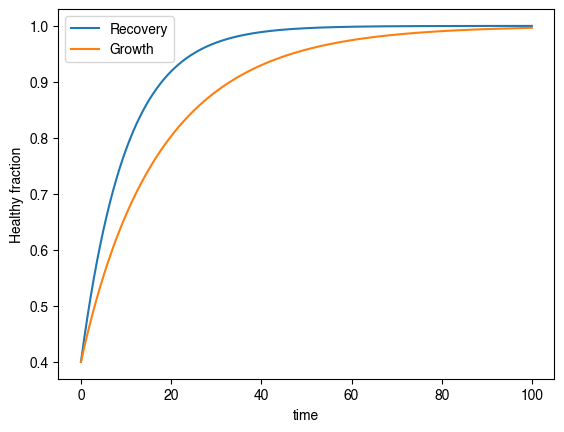

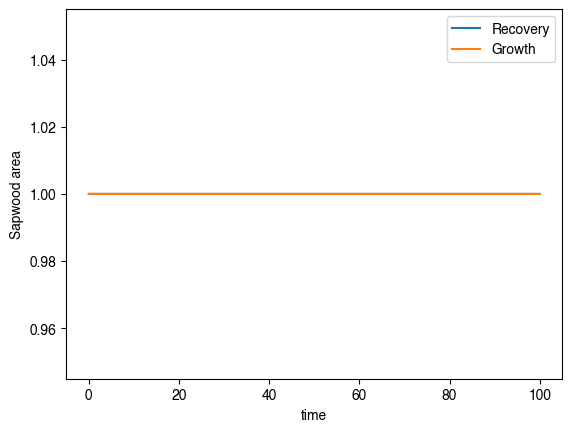

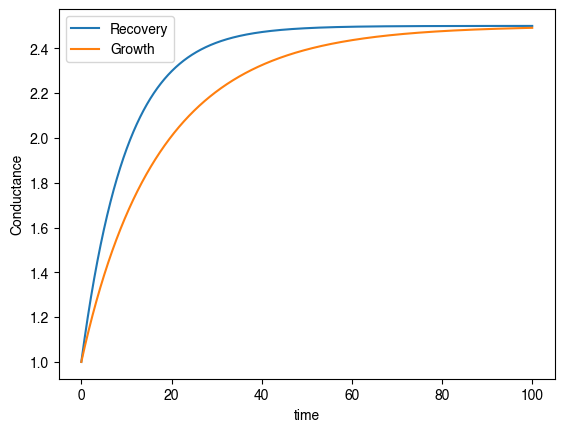

In [5]:
# -- Initial conditions --
f_h_init = 0.4
A_sap_init = 1
k_init = 1

# -- System parameters
N_steps = 10000
time_step = 0.01

recovery_rate = 0.1

growth_rate = 0.1
death_shape = 0.5

# -- Array setup --
time = np.zeros(N_steps)

recovery_f_h = np.zeros(N_steps)
growth_f_h   = np.zeros(N_steps)

recovery_A_sap = np.zeros(N_steps)
growth_A_sap   = np.zeros(N_steps)

recovery_k = np.zeros(N_steps)
growth_k   = np.zeros(N_steps)

recovery_f_h[0] = f_h_init
growth_f_h[0]   = f_h_init

recovery_A_sap[0] = A_sap_init
growth_A_sap[0]   = A_sap_init

recovery_k[0] = k_init
growth_k[0]   = k_init

# -- calculate over time steps --
for i in range(1,N_steps):
    time[i] = time[i-1] + time_step
    recovery_f_h[i] = update_f_h(recovery_f_h[i-1], time_step, 0          , 0          , recovery_rate, 0, 0)
    growth_f_h[i]   = update_f_h(growth_f_h[i-1]  , time_step, growth_rate, growth_rate, 0            , 0, death_shape)

    recovery_A_sap[i] = update_A_sap(recovery_A_sap[i-1], time_step, 0          , 0          )
    growth_A_sap[i]   = update_A_sap(growth_A_sap[i-1]  , time_step, growth_rate, growth_rate)

    recovery_k[i] = update_k(recovery_A_sap[i], recovery_f_h[i], A_sap_init, f_h_init, k_init)
    growth_k[i]   = update_k(growth_A_sap[i]  , growth_f_h[i]  , A_sap_init, f_h_init, k_init)

# -- Plot healthy fraction --
plt.plot(time, recovery_f_h, label = "Recovery")
plt.plot(time, growth_f_h, label = "Growth")

plt.xlabel("time")
plt.ylabel("Healthy fraction")

plt.legend()
plt.show()

# -- Plot sapwood area --
plt.plot(time, recovery_A_sap, label = "Recovery")
plt.plot(time, growth_A_sap, label = "Growth")

plt.xlabel("time")
plt.ylabel("Sapwood area")

plt.legend()
plt.show()

# -- Plot conductance --
plt.plot(time, recovery_k, label = "Recovery")
plt.plot(time, growth_k, label = "Growth")

plt.xlabel("time")
plt.ylabel("Conductance")

plt.legend()
plt.show()

## Perturbing stable states

Lets test how the model handles a pertibation in the form of sudden imparement to the healthy xylem.

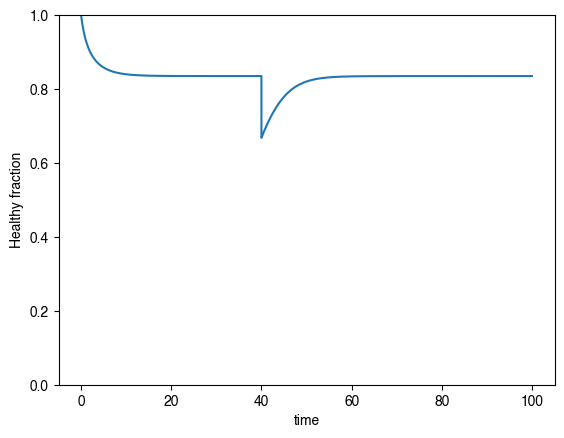

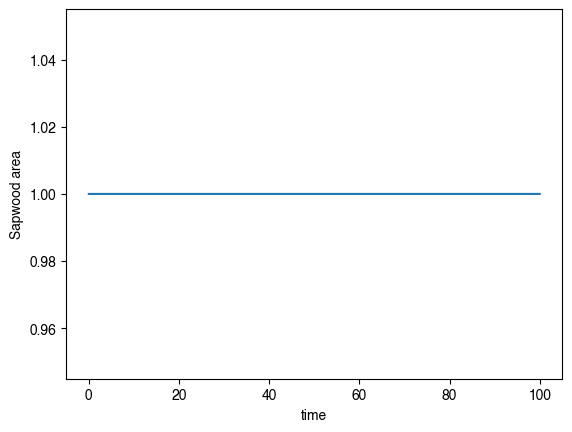

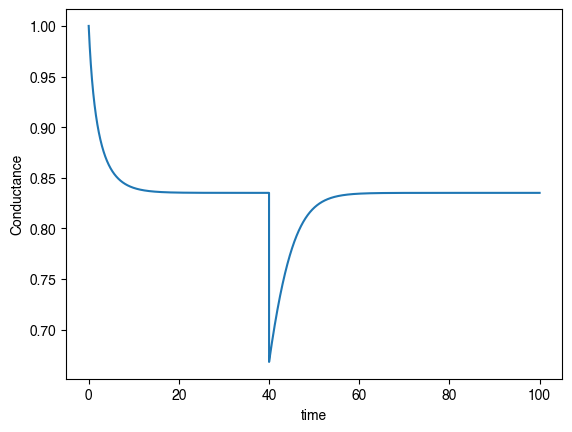

In [6]:
# -- Initial conditions --
f_h_init = 1.
A_sap_init = 1
k_init = 1

# -- Experiment parameters --
N_steps = 10000
pertibation_step = 4000
time_step = 0.01

recovery_rate = 0
imparement_rate = 0.1

growth_rate = 0.1
death_rate = 0.1
death_shape = 10

pertibation_imparement_rate = 20

# -- Array setup --
time  = np.zeros(N_steps)
f_h   = np.zeros(N_steps)
A_sap = np.zeros(N_steps)
k     = np.zeros(N_steps)

f_h[0] = f_h_init
A_sap[0] = A_sap_init
k[0] = k_init

# -- Calcualte initial time steps --
for i in range(1,pertibation_step):
    time[i] = time[i-1] + time_step
    f_h[i]   = update_f_h(  f_h[i-1]  , time_step, growth_rate, death_rate, recovery_rate, imparement_rate, death_shape)
    A_sap[i] = update_A_sap(A_sap[i-1], time_step, growth_rate, death_rate)
    k[i] = update_k(A_sap[i], f_h[i], A_sap_init, f_h_init, k_init)
    
# -- Apply peribation --
time[pertibation_step] = time[pertibation_step - 1] + time_step
f_h[pertibation_step]   = update_f_h(f_h[pertibation_step-1]    , time_step, 0, 0, 0, pertibation_imparement_rate, death_shape)
A_sap[pertibation_step] = update_A_sap(A_sap[pertibation_step-1], time_step, 0, 0)
k[pertibation_step] = update_k(A_sap[pertibation_step], f_h[pertibation_step], A_sap_init, f_h_init, k_init)

# -- Calculate final time steps --
for i in range(pertibation_step+1, N_steps):
    time[i] = time[i-1] + time_step
    f_h[i]   = update_f_h(f_h[i-1]    , time_step, growth_rate, death_rate, recovery_rate, imparement_rate, death_shape)
    A_sap[i] = update_A_sap(A_sap[i-1], time_step, growth_rate, death_rate)
    k[i] = update_k(A_sap[i], f_h[i], A_sap_init, f_h_init, k_init)

# -- Plot healthy fraction --
plt.plot(time, f_h)
plt.xlabel("time")
plt.ylabel("Healthy fraction")
plt.ylim(0,1)
plt.show()

# -- Plot sapwood area --
plt.plot(time, A_sap)
plt.xlabel("time")
plt.ylabel("Sapwood area")
plt.show()

# -- Plot conductance --
plt.plot(time, k)
plt.xlabel("time")
plt.ylabel("Conductance")
plt.show()

Lets now try a sudden sapwood death event.

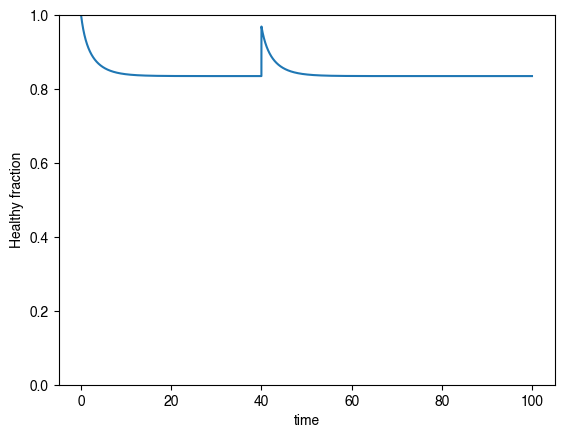

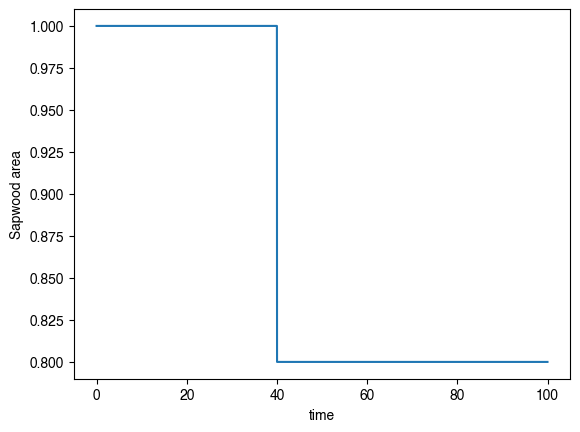

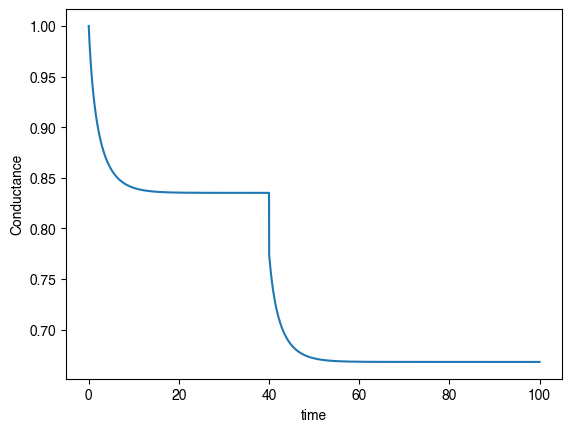

In [7]:
# -- Initial conditions --
f_h_init = 1.0
A_sap_init = 1
k_init = 1

# -- Experiment parameters --
N_steps = 10000
pertibation_step = 4000
time_step = 0.01

recovery_rate = 0
imparement_rate = 0.1

growth_rate = 0.1
death_rate = 0.1
death_shape = 10

pertibation_death_rate = 20

# -- Array setup --
time  = np.zeros(N_steps)
f_h   = np.zeros(N_steps)
A_sap = np.zeros(N_steps)
k     = np.zeros(N_steps)

f_h[0] = f_h_init
A_sap[0] = A_sap_init
k[0] = k_init

# -- Calcualte initial time steps --
for i in range(1,pertibation_step):
    time[i] = time[i-1] + time_step
    f_h[i]   = update_f_h(  f_h[i-1]  , time_step, growth_rate, death_rate, recovery_rate, imparement_rate, death_shape)
    A_sap[i] = update_A_sap(A_sap[i-1], time_step, growth_rate, death_rate)
    k[i] = update_k(A_sap[i], f_h[i], A_sap_init, f_h_init, k_init)
    
# -- Apply peribation --
time[pertibation_step] = time[pertibation_step - 1] + time_step
f_h[pertibation_step]   = update_f_h(f_h[pertibation_step-1]    , time_step, 0, pertibation_death_rate, 0, 0, death_shape)
A_sap[pertibation_step] = update_A_sap(A_sap[pertibation_step-1], time_step, 0, pertibation_death_rate)
k[pertibation_step] = update_k(A_sap[pertibation_step], f_h[pertibation_step], A_sap_init, f_h_init, k_init)

# -- Calculate final time steps --
for i in range(pertibation_step+1, N_steps):
    time[i] = time[i-1] + time_step
    f_h[i]   = update_f_h(f_h[i-1]    , time_step, growth_rate, death_rate, recovery_rate, imparement_rate, death_shape)
    A_sap[i] = update_A_sap(A_sap[i-1], time_step, growth_rate, death_rate)
    k[i] = update_k(A_sap[i], f_h[i], A_sap_init, f_h_init, k_init)

# -- Plot healthy fraction --
plt.plot(time, f_h)
plt.xlabel("time")
plt.ylabel("Healthy fraction")
plt.ylim(0,1)
plt.show()

# -- Plot sapwood area --
plt.plot(time, A_sap)
plt.xlabel("time")
plt.ylabel("Sapwood area")
plt.show()

# -- Plot conductance --
plt.plot(time, k)
plt.xlabel("time")
plt.ylabel("Conductance")
plt.show()

# Adding this to a profit optimisation model

Having outlined the general principles of the model we want to intergrate it into the toy profit optimisation model. The profit toy optimisation model does not contain tree growth or death in any form so we leave the asosited rates as external inputs, this is the same aproach as above. The rates of xylem recovery and imparement on the other hand we relate to the current leaf water potnential $\psi_l$ as,

$$
r(t) = R(\frac{k_l(t)}{k_{max}})^{s_r}
$$

$$
i(t) = I(1 - \frac{k_l(t)}{k_{max}})^{s_i}
$$

where $k_{max}$ is the current maximum conductance, $R$ and $I$ are posative constants and $s_r$ and $s_i$ are shape parameters. This formulation means that the rate of recovery (imparment) increases as the conductance at the leaf aproaches $k_{max}$ (zero) and decreases to zero as the conductance at the leaf aproaches zero ($k_{max}$). 

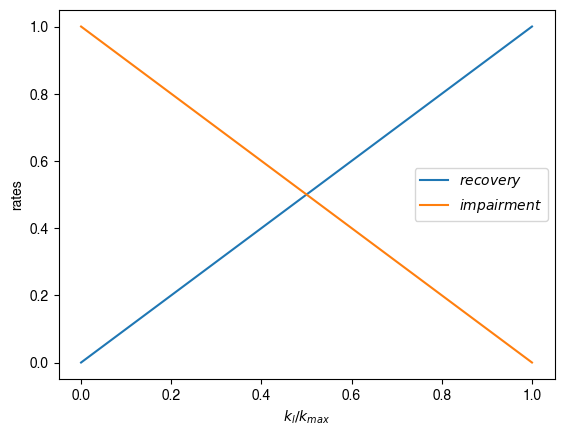

In [8]:
def r(k_l, R, k_max, r_shape_param):
    return R*(k_l/k_max)**r_shape_param

def i(k_l, I, k_max, I_shape_param):
    return I * (1 - k_l/k_max)**i_shape_param

k_l_array = np.linspace(0, 1, 1000)
k_max = 1
R = 1.
I = 1.
r_shape_param = 1.
i_shape_param = 1.

r_array = r(k_l_array, R, k_max, r_shape_param)
i_array = i(k_l_array, I, k_max, i_shape_param)

plt.plot(k_l_array, r_array, label = "$recovery$")
plt.plot(k_l_array, i_array, label = "$impairment$")
plt.legend()
plt.xlabel("$k_l / k_{max}$")
plt.ylabel("rates")
plt.show()

## Model creation

Now let us create two profit optimisation models, one uses a simple static model and the other uses the dynamic xylem model above with both making use of a cumulative Weibull distribution as the xylem vulnerability curve. To maintain a steady state with respect to sapwood area we will set the growth and death rates equal to one another.

### Conductance model

In [9]:
# Conductance model
P50 = -3. # MPa
P88 = -4. # MPa
k_max = 0.2 # mmol m-2 s-1 MPa-1

critical_conductance_loss_fraction = 0.9

sapwood_area = 1
growth_rate = 0.01
death_rate = 0.01
death_shape = 10.
recovery_rate = 0.01
recovery_shape_parameter = 1.
impairment_rate = 0.04
impairment_shape_parameter = 1.

default_CW_conductance_model = cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials(k_max,
                                                                                                               P50,
                                                                                                               P88,
                                                                                                               0.50,
                                                                                                               0.88,
                                                                                                               critical_conductance_loss_fraction
                                                                                                              )

dynamic_CW_conductance_model = JB_xylem_damage_model_from_conductance_loss(k_max,
                                                                           sapwood_area,
                                                                           P50,
                                                                           P88,
                                                                           0.5,
                                                                           0.88,
                                                                           critical_conductance_loss_fraction,
                                                                           recovery_rate,
                                                                           recovery_shape_parameter,
                                                                           impairment_rate,
                                                                           impairment_shape_parameter,
                                                                           growth_rate,
                                                                           death_rate,
                                                                           death_shape
                                                                          )


### Hydraulic cost model

In [10]:
critical_leaf_water_potential = default_CW_conductance_model.water_potential_from_conductivity_loss_fraction(critical_conductance_loss_fraction)

default_CW_hydraulic_cost_model = HydraulicCostModel(default_CW_conductance_model,
                                                     critical_leaf_water_potential
                                                    )

dynamic_CW_hydraulic_cost_model = HydraulicCostModel(dynamic_CW_conductance_model,
                                                     critical_leaf_water_potential
                                                    )

### Leaf atmospher coupling model

In [11]:
leaf_air_coupling_model = LeafAirCouplingModel()

### Photosynthesis model

In [12]:
# -- Rubisco limited model --
photosynthesis_rubisco_limited_model = PhotosynthesisModelRubiscoLimited()

# -- Electron transport rate limmited model --
photosynthesis_electron_transport_limited_model = PhotosynthesisModelElectronTransportLimited()

photosynthesis_model = PhotosynthesisModel(photosynthesis_rubisco_limited_model,
                                           photosynthesis_electron_transport_limited_model
                                          )

### CO2 gain

In [13]:
CO2_gain_model = CO2GainModel(leaf_air_coupling_model,
                              photosynthesis_model)

### Profit optimisation models

In [14]:
default_CW_profit_optimisation_model = ProfitMaxModel(default_CW_hydraulic_cost_model,
                                                      leaf_air_coupling_model,
                                                      CO2_gain_model
                                                     )

dynamic_CW_profit_optimisation_model = ProfitMaxModel(dynamic_CW_hydraulic_cost_model,
                                                      leaf_air_coupling_model,
                                                      CO2_gain_model
                                                     )

profit_optimisation_models = [default_CW_profit_optimisation_model,
                              dynamic_CW_profit_optimisation_model]

profit_optimisation_model_labels = ["default", "dynamic"]

# Model testing
## Constant environmental conditions

First lets test how the model behaves under the constant environmental conditions outlined in the code block bellow.

In [15]:
# Soil properties
soil_water_potential = -1.0 # MPa

# Temperature
air_temperature = degrees_centigrade_to_kelvin(25.)

# Transpiration drivers
air_vapour_pressure_deficit = 1 # kPa
air_pressure = 101.9 # kPa

# Photosynthesis drivers
atmospheric_CO2_concentration = 419. # (umol mol-1)
photosynthetically_active_radiation = 1000. #(umol m-2 s-1)
intercellular_oxygen = 210.0 #(umol mol-1)

Lets run the simulation for $100$ time steps.

In [16]:
time_steps = 100
time_step_size = 1. # h

number_of_models = len(profit_optimisation_models)

time = [i*time_step_size for i in range(time_steps)]

# Number of sample points used when finding optimal leaf water potential
number_of_sample_points = 1000

# -- setup output arrays --
optimal_leaf_water_potential = np.zeros([number_of_models, time_steps])
net_CO2_uptake               = np.zeros([number_of_models, time_steps])
transpiration_rate           = np.zeros([number_of_models, time_steps])
intercellular_CO2            = np.zeros([number_of_models, time_steps])
stomatal_conductance_to_CO2  = np.zeros([number_of_models, time_steps])
k_max                        = np.zeros([number_of_models, time_steps])
k                            = np.zeros((number_of_models, time_steps))
PLC                          = np.zeros([number_of_models, time_steps])

for i in range(number_of_models):
    for j in range(time_steps):
        [optimal_leaf_water_potential[i,j],
         net_CO2_uptake[i,j],
         transpiration_rate[i,j],
         intercellular_CO2[i,j],
         stomatal_conductance_to_CO2[i,j]] = profit_optimisation_models[i].calculate_time_step(time_step_size,
                                                                                               soil_water_potential,
                                                                                               air_temperature,
                                                                                               air_vapour_pressure_deficit,
                                                                                               air_pressure,
                                                                                               atmospheric_CO2_concentration,
                                                                                               intercellular_oxygen,
                                                                                               photosynthetically_active_radiation,
                                                                                               number_of_sample_points)

        k_max[i,j] = profit_optimisation_models[i].hydraulic_cost_model.hydraulic_conductance_model.maximum_conductance
        k[i,j]     = profit_optimisation_models[i].hydraulic_cost_model.hydraulic_conductance_model.conductance(optimal_leaf_water_potential[i,j])
        
        PLC[i,j]   = profit_optimisation_models[i].hydraulic_cost_model.hydraulic_conductance_model.PLC(optimal_leaf_water_potential[i,j])

        if(i == 1 and False):
            print(dynamic_CW_profit_optimisation_model.hydraulic_cost_model.hydraulic_conductance_model.healthy_fraction)


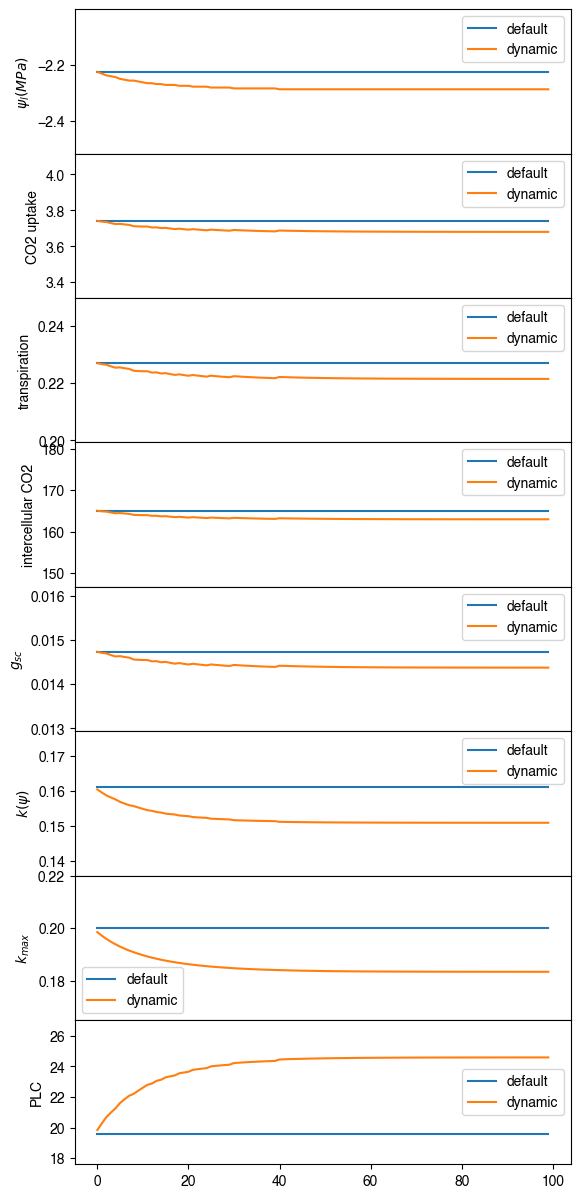

In [17]:

plot_y_labels = ["$\psi_l (MPa)$",
                 "CO2 uptake",
                 "transpiration",
                 "intercellular CO2",
                 "$g_{sc}$",
                 "$k(\psi)$",
                 "$k_{max}$",
                 "PLC"]

plot_values = [optimal_leaf_water_potential,
               net_CO2_uptake,
               transpiration_rate,
               intercellular_CO2,
               stomatal_conductance_to_CO2,
               k,
               k_max,
               PLC]

# -- plot and format subfigures --
fig, axs = plt.subplots(len(plot_values),1, sharex = True)

for i in range(0,len(plot_values)):
    for j in range(number_of_models):
        axs[i].plot(time, plot_values[i][j],
                    label = profit_optimisation_model_labels[j])
    axs[i].set_ylabel(plot_y_labels[i])
    axs[i].legend()

    # Set limits
    min_value = np.min(plot_values[i])
    max_value = np.max(plot_values[i])

    min_value -= 0.1*np.absolute(min_value)
    max_value += 0.1*np.absolute(max_value)
    
    axs[i].set_ylim(min_value, max_value)

# -- Format figure --
plt.subplots_adjust(wspace=0, hspace=0)
fig.set_figheight(15)

plt.show()

## Soil dry down and recovery

In [18]:
# Reset the conductance models xylem damage.
for current_model in profit_optimisation_models:
    current_model.hydraulic_cost_model.hydraulic_conductance_model.reset_xylem_damage()

# -- setup soil water potential values --
time_steps = 300
soil_water_potentials = np.zeros(time_steps)

soil_water_potentials[0:100] = -0.5 # MPa
soil_water_potentials[100:200] = np.linspace(-0.5,-3.,100) # MPa
soil_water_potentials[200:] = -0.5 # MPa

# -- setup time --
time = [i*time_step_size for i in range(time_steps)]

# -- setup output arrays --
optimal_leaf_water_potential = np.zeros([number_of_models, time_steps])
net_CO2_uptake               = np.zeros([number_of_models, time_steps])
transpiration_rate           = np.zeros([number_of_models, time_steps])
intercellular_CO2            = np.zeros([number_of_models, time_steps])
stomatal_conductance_to_CO2  = np.zeros([number_of_models, time_steps])
k_max                        = np.zeros([number_of_models, time_steps])
k_leaf                       = np.zeros([number_of_models, time_steps])
PLC                          = np.zeros([number_of_models, time_steps])

for i in range(number_of_models):
    for j in range(time_steps):
        [optimal_leaf_water_potential[i,j],
         net_CO2_uptake[i,j],
         transpiration_rate[i,j],
         intercellular_CO2[i,j],
         stomatal_conductance_to_CO2[i,j]] = profit_optimisation_models[i].calculate_time_step(time_step_size,
                                                                                               soil_water_potentials[j],
                                                                                               air_temperature,
                                                                                               air_vapour_pressure_deficit,
                                                                                               air_pressure,
                                                                                               atmospheric_CO2_concentration,
                                                                                               intercellular_oxygen,
                                                                                               photosynthetically_active_radiation,
                                                                                               number_of_sample_points)

        k_max[i,j] = profit_optimisation_models[i].hydraulic_cost_model.hydraulic_conductance_model.maximum_conductance
        k_leaf[i,j] = profit_optimisation_models[i].hydraulic_cost_model.hydraulic_conductance_model.conductance(optimal_leaf_water_potential[i,j])
        
        PLC[i,j]   = profit_optimisation_models[i].hydraulic_cost_model.hydraulic_conductance_model.PLC(optimal_leaf_water_potential[i,j])


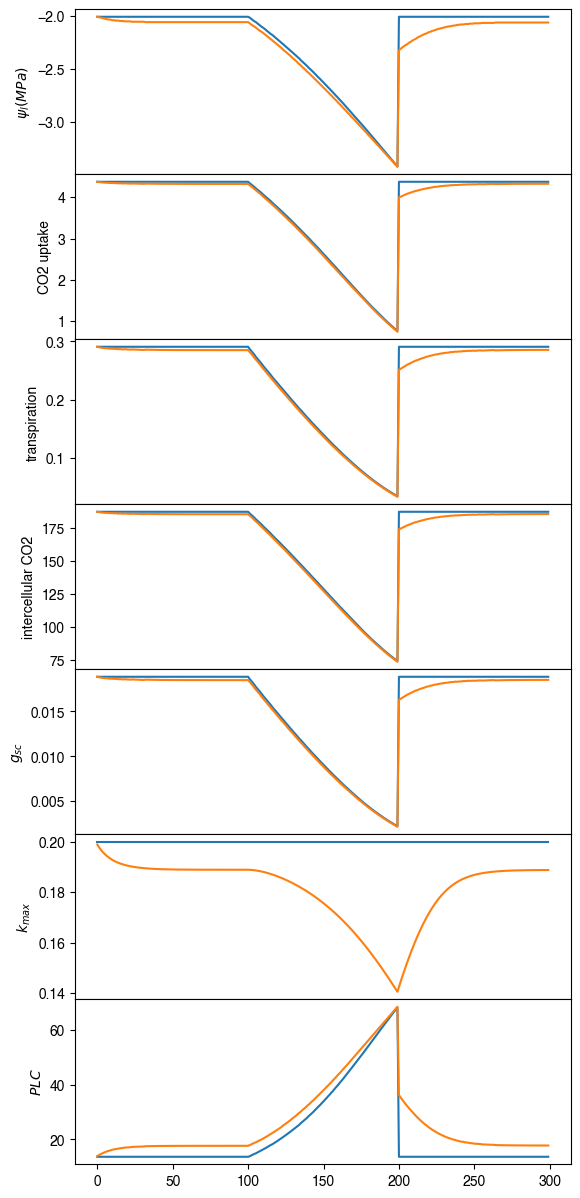

In [19]:
plot_y_labels = ["$\psi_l (MPa)$",
                 "CO2 uptake",
                 "transpiration",
                 "intercellular CO2",
                 "$g_{sc}$",
                 "$k_{max}$",
                 "$PLC$"
                ]

plot_values = [optimal_leaf_water_potential,
               net_CO2_uptake,
               transpiration_rate,
               intercellular_CO2,
               stomatal_conductance_to_CO2,
               k_max,
               PLC
              ]

# -- plot and format subfigures --
fig, axs = plt.subplots(len(plot_values),1, sharex = True)

for i in range(len(plot_values)):
    for j in range(number_of_models):
        axs[i].plot(time, plot_values[i][j], label = profit_optimisation_model_labels[j])

    axs[i].set_ylabel(plot_y_labels[i])
    #axs[i].legend(loc = "lower left")

# -- Format figure --
plt.subplots_adjust(wspace=0, hspace=0)
fig.set_figheight(15)

plt.show()